In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

path_data ='//netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/'
path_las = '//netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/well logs/'
path_wvlt = '//netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/wavelets/'
fig_path = 'M:/LOCRETA_WORKPACKAGE_D/Valdemar_sprint_well_data_Mads_L/MLO documents/Figures/'
path_hrs = '//netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/HRS project/Locreta_proj_Mads_localtest.prj/seismic.dir/'

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['axes.labelsize'] = 'medium'
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasRegressor

# Splitting data

In [11]:
path_project = '//netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/well logs/locreta_ml/'
df= pd.read_csv(path_project+'wells_merged_new.csv')
df

,UWI,DEPTH,GRN,Vp,Vs,RHOB,CALI,CNC,BIT,Formation,Zone_encoded,ILM_log10
0,BO-2X,2355.0372,2.57677,3.857078,2.028566,2.46854,8.7640,20.532,8.5,Rødby,0,0.609682
1,BO-2X,2355.1896,7.17105,3.747464,1.963796,2.46004,8.7870,21.391,8.5,Rødby,0,0.588876
2,BO-2X,2355.3420,12.06749,3.634318,1.896416,2.44804,8.8270,22.345,8.5,Rødby,0,0.561447
3,BO-2X,2355.4944,17.33202,3.526553,1.829911,2.43479,8.8320,23.320,8.5,Rødby,0,0.529027
4,BO-2X,2355.6468,22.95544,3.421846,1.765272,2.42301,8.8180,24.274,8.5,Rødby,0,0.493480
...,...,...,...,...,...,...,...,...,...,...,...,...
5129,VALDEMAR-2H,3359.3532,42.09327,2.842439,1.448258,2.32068,9.4766,33.668,8.5,L.Tuxen-1,15,0.632328
5130,VALDEMAR-2H,3364.8396,40.90633,2.952384,1.448430,2.38409,9.4766,32.206,8.5,L.Tuxen-1,15,0.659406
5131,VALDEMAR-2H,3370.3260,37.07852,2.720559,1.446433,2.16285,9.4766,35.153,8.5,L.Tuxen-1,15,0.653828
5132,VALDEMAR-2H,3375.8124,33.88726,3.099774,1.438454,2.16722,9.7500,35.888,8.5,L.Tuxen-1,15,0.585335


In [15]:
features = ['GRN',
 'Vp',
 'CNC',
 'ILM_log10']

target = ['Vs']

train_wells = ['JUDE-1','VALDEMAR-2H', 'BOJE-2C','SIAH_NE-01X']

X_train = df.loc[df['UWI'].isin(train_wells), features].values
y_train = df.loc[df['UWI'].isin(train_wells), target].values

# And we might need this later...
wells_train = df.loc[df['UWI'].isin(train_wells), 'UWI'].values

test_wells = ['BO-2X', 'BO-3X']

X_test = df.loc[df['UWI'].isin(test_wells), features].values
y_test = df.loc[df['UWI'].isin(test_wells), target].values
len(features)

test_logs = pd.DataFrame(y_test, columns = ['true'])

#plt.figure(figsize=(10, 5))
#ax = df.groupby('UWI').NEUT.count().plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5'])
#plt.ylim(0,1300)
#plt.xticks(rotation = 0, fontsize = 13)
#plt.xlabel('Well name')
#plt.ylabel('Counts')
#for p in ax.patches:
#    ax.annotate(str(p.get_height()),(p.get_x()+p.get_width()/2., 
#                                     p.get_height()),    ha='center',   va='center',   xytext=(0, 10),  textcoords='offset points') 
#plt.savefig(fig_path+'wells_counts.png',format='png', bbox_inches='tight') 

In [16]:
#plt.scatter(x=df['DTS'],y = df['DENS'], c = df['DEPTH'], cmap  = 'viridis')
#plt.colorbar()

# Setting up pipelines

In [17]:
regr1 = LinearRegression()
regr2 = RandomForestRegressor(random_state=42, n_jobs=5)
regr3 = SVR()
regr4 = MLPRegressor(max_iter=1000, random_state=42, early_stopping=True, validation_fraction=0.2)



# Building the pipelines
pipe_LR = Pipeline([('std', StandardScaler()),
                  ('LR', regr1)])

pipe_RFR = Pipeline([('RFR', regr2)])

pipe_SVR = Pipeline([('std', StandardScaler()),
                 ('SVR', regr3)])

pipe_MLP = Pipeline([('std', StandardScaler())
                 , ('MLP', regr4)])

# Setting up the parameter grids
param_grid_LR = [{}]

param_grid_RFR = [{ 
 'RFR__max_depth': [5, 8 ,10 ,15 ],
 'RFR__min_samples_leaf': [ 8, 10, 12],
 'RFR__min_samples_split': [2,3,4],
 'RFR__n_estimators': [600 ,800, 1000] }]


param_grid_SVR = [{'SVR__kernel' : ['linear','rbf'],
                    'SVR__C': np.power(10., np.arange(-4, 4)),
                  'SVR__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}]

param_grid_MLP = [{"MLP__hidden_layer_sizes": [(8,8), (14,14), (20, 20)],
                 "MLP__activation": ["relu"],
                 'MLP__learning_rate': ['constant','adaptive'],
                 'MLP__solver' : ['lbfgs','adam'],
                 "MLP__alpha": np.power(10., np.arange(-6, 0)),
                 "MLP__max_iter": [4000],
                  "MLP__n_iter_no_change":[10]}]

# Nested CV

In [ ]:
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

X_tr = df.loc[df['UWI'].isin(train_wells), features]
y_tr = df.loc[df['UWI'].isin(train_wells), target]
X_ts = df.loc[df['UWI'].isin(test_wells), features]
y_ts = df.loc[df['UWI'].isin(test_wells), target]

logo = LeaveOneGroupOut()
k=0

nested_score_LR = []
nested_score_RFR = []
nested_score_SVR = []
nested_score_MLP = []

for train_index, test_index in logo.split(X_tr, y_tr, wells_train):
    print('Iter #:', k)
    X_trn, X_tst = X_tr.iloc[train_index], X_tr.iloc[test_index]
    y_trn, y_tst = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    print('test well :', df.loc[X_tst.index[-1]]['UWI'])


    wells_train_inner = train_wells.copy()
    wells_train_inner.remove(df.loc[X_tst.index[-1]]['UWI'])
    
    print('training wells:', wells_train_inner)
    
    X_tr_ = df.loc[df['UWI'].isin(wells_train_inner), features].values
    y_tr_ = np.squeeze(df.loc[df['UWI'].isin(wells_train_inner), target].values)


    wells_train_inner = df.loc[df['UWI'].isin(wells_train_inner), 'UWI'].values
    
    #LR
    gcv_LR = GridSearchCV(pipe_LR, param_grid_LR, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut(), n_jobs=-1)
    results_LR = gcv_LR.fit(X_tr_, y_tr_, groups=wells_train_inner)
    model_LR = results_LR.best_estimator_.fit(X_tr_, y_tr_)
    model_score_LR = model_LR.predict(X_tst)
    nested_score_LR.append(mean_squared_error(y_tst,model_score_LR, squared=False))
    
    #RFR
    gcv_RFR = GridSearchCV(pipe_RFR, param_grid_RFR, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut(), n_jobs=-1)
    results_RFR = gcv_RFR.fit(X_tr_, y_tr_, groups=wells_train_inner)
    print(results_RFR.best_estimator_)
    model_RFR = results_RFR.best_estimator_.fit(X_tr_, y_tr_)
    model_score_RFR = model_RFR.predict(X_tst)
    nested_score_RFR.append(mean_squared_error(y_tst,model_score_RFR, squared=False))
    
    
    #SVR
    gcv_SVR = GridSearchCV(pipe_SVR, param_grid_SVR, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut(), n_jobs=-1)
    results_SVR = gcv_SVR.fit(X_tr_, y_tr_, groups=wells_train_inner)
    print(results_SVR.best_estimator_)
    model_SVR = results_SVR.best_estimator_.fit(X_tr_, y_tr_)
    model_score_SVR = model_SVR.predict(X_tst)
    nested_score_SVR.append(mean_squared_error(y_tst,model_score_SVR, squared=False))
    
    #MLP
    gcv_MLP = GridSearchCV(pipe_MLP, param_grid_MLP, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut(), n_jobs=-1)
    results_MLP = gcv_MLP.fit(X_tr_, y_tr_, groups=wells_train_inner)
    print(results_MLP.best_estimator_)
    model_MLP = results_MLP.best_estimator_.fit(X_tr_, y_tr_)
    model_score_MLP = model_MLP.predict(X_tst)
    nested_score_MLP.append(mean_squared_error(y_tst,model_score_MLP, squared=False))
    
    k+=1

Iter #: 0
test well : BOJE-2C
training wells: ['JUDE-1', 'VALDEMAR-2H', 'SIAH_NE-01X']


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Pipeline(steps=[('RFR',
                 RandomForestRegressor(max_depth=8, min_samples_leaf=8,
                                       n_estimators=600, n_jobs=5,
                                       random_state=42))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Pipeline(steps=[('std', StandardScaler()), ('SVR', SVR(C=100.0, gamma=0.0001))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Pipeline(steps=[('std', StandardScaler()),
                ('MLP',
                 MLPRegressor(alpha=0.1, early_stopping=True,
                              hidden_layer_sizes=(8, 8), max_iter=4000,
                              random_state=42, solver='lbfgs',
                              validation_fraction=0.2))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iter #: 1
test well : JUDE-1
training wells: ['VALDEMAR-2H', 'BOJE-2C', 'SIAH_NE-01X']
Pipeline(steps=[('RFR',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=8,
                                       n_estimators=1000, n_jobs=5,
                                       random_state=42))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Pipeline(steps=[('std', StandardScaler()), ('SVR', SVR(C=0.01, gamma=0.1))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Pipeline(steps=[('std', StandardScaler()),
                ('MLP',
                 MLPRegressor(alpha=0.01, early_stopping=True,
                              hidden_layer_sizes=(8, 8), max_iter=4000,
                              random_state=42, solver='lbfgs',
                              validation_fraction=0.2))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iter #: 2
test well : SIAH_NE-01X
training wells: ['JUDE-1', 'VALDEMAR-2H', 'BOJE-2C']
Pipeline(steps=[('RFR',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=8,
                                       min_samples_split=3, n_estimators=800,
                                       n_jobs=5, random_state=42))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Pipeline(steps=[('std', StandardScaler()), ('SVR', SVR(C=1000.0, gamma=0.001))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Pipeline(steps=[('std', StandardScaler()),
                ('MLP',
                 MLPRegressor(alpha=0.1, early_stopping=True,
                              hidden_layer_sizes=(14, 14), max_iter=4000,
                              random_state=42, validation_fraction=0.2))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iter #: 3
test well : VALDEMAR-2H
training wells: ['JUDE-1', 'BOJE-2C', 'SIAH_NE-01X']
Pipeline(steps=[('RFR',
                 RandomForestRegressor(max_depth=8, min_samples_leaf=12,
                                       min_samples_split=3, n_estimators=800,
                                       n_jobs=5, random_state=42))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Pipeline(steps=[('std', StandardScaler()), ('SVR', SVR(C=100.0, gamma=0.01))])


C:\Users\MLO\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
nested_cv = pd.DataFrame(data = np.array([nested_score_LR, nested_score_RFR, nested_score_SVR, nested_score_MLP]).T, columns = ['LR','RFR','SVR', 'MLP'])
nested_cv.to_csv(path_project+'nested_cv.csv',index=False)

In [ ]:
nested_cv= pd.read_csv(path_project+'nested_cv.csv')

In [ ]:
nested_cv

Text(-0.35000000000000003, 0.18134892458688143, 'Figure 9')

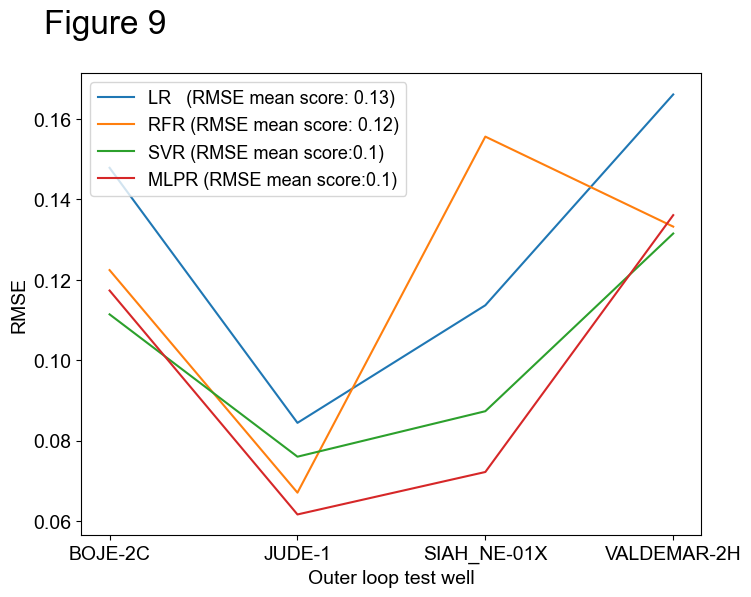

In [9]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(4), nested_cv['LR']  , label = 'LR   (RMSE mean score: {})'.format(np.round(np.mean(nested_cv['LR'] ),2)))
plt.plot(np.arange(4), nested_cv['RFR'] , label = 'RFR (RMSE mean score: {})'.format( np.round(np.mean(nested_cv['RFR']),2)))
plt.plot(np.arange(4), nested_cv['SVR'] , label = 'SVR (RMSE mean score:{})'.format(  np.round(np.mean(nested_cv['SVR']),2)))
plt.plot(np.arange(4), nested_cv['MLP'] , label = 'MLPR (RMSE mean score:{})'.format( np.round(np.mean(nested_cv['MLP']),2)))
plt.ylabel('RMSE')
plt.xlabel('Outer loop test well')
plt.xticks([0,1,2,3],labels = ['BOJE-2C', 'JUDE-1', 'SIAH_NE-01X', 'VALDEMAR-2H'])
plt.legend(fontsize = 13)

plt.text(x = plt.xlim()[0]-.2,   y = plt.ylim()[1]+0.01, s = 'Figure 9',fontsize=24)
#print('mean score LR :' , np.mean(nested_score_LR ) , 'Std:', np.std(nested_score_LR ))
#print('mean score RFR:' , np.mean(nested_score_RFR) , 'Std:', np.std(nested_score_RFR))
#print('mean score SVR:' , np.mean(nested_score_SVR) , 'Std:', np.std(nested_score_SVR))
#print('mean score MLP:' , np.mean(nested_score_MLP) , 'Std:', np.std(nested_score_MLP))
##plt.savefig(fig_path+'nested_cv.pdf',format='pdf', bbox_inches='tight')

# Predictions on BO-2X and BO-3X

In [14]:
estimator_lr = Pipeline(steps=[('std', StandardScaler()), ('LR', LinearRegression())])

estimator_rfr = Pipeline(steps=[('RFR',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=7,
                                       n_estimators=800, n_jobs=5,
                                       random_state=42))])

estimator_svr = Pipeline(steps=[('std', StandardScaler()), ('SVR', SVR(C=0.01, gamma=0.1))])

estimator_mlp = Pipeline(steps=[('std', StandardScaler()),
                ('MLP',
                 MLPRegressor(alpha=0.01, early_stopping=True,
                              hidden_layer_sizes=(8, 8), max_iter=4000,
                              random_state=42, solver='lbfgs',
                              validation_fraction=0.2))])

In [15]:
# LINEAR REGRESSION
#logo = LeaveOneGroupOut().split(X_train, y_train, groups=wells_train)
#estimator_lr = GridSearchCV(pipe_LR, param_grid_LR, scoring='neg_root_mean_squared_error', cv=logo, verbose = 1, n_jobs=-1)  
estimator_lr.fit(X_train, np.squeeze(y_train))
test_logs['lr'] = estimator_lr.predict(X_test)
print('LR DONE')


# SUPPORTVECTOR REGRESSION
#logo = LeaveOneGroupOut().split(X_train, y_train, groups=wells_train)
#estimator_svr = GridSearchCV(pipe_SVR, param_grid_SVR, scoring='neg_root_mean_squared_error', cv=logo, verbose = 1, n_jobs=-1)  
estimator_svr.fit(X_train, np.squeeze(y_train))
#print(estimator_svr.best_params_)
#pipe_SVR.fit(X_train, y_train)

test_logs['svr'] = estimator_svr.predict(X_test)
print('SVR DONE')

# RANDOMFOREST
#logo = LeaveOneGroupOut().split(X_train, y_train, groups=wells_train)
#pipe_RFR = Pipeline([('s',rfe), ('RFR', regr2)])
#estimator_rfr = GridSearchCV(pipe_RFR, param_grid_RFR, scoring='neg_root_mean_squared_error', cv=logo, verbose = 1, n_jobs=-1)
estimator_rfr.fit(X_train, np.squeeze(y_train))
#pipe_RFR.set_params(**estimator_rfr.best_params_)
#pipe_RFR.fit(X_train, y_train)
test_logs['rfr'] = estimator_rfr.predict(X_test)
print('RFR DONE')

#logo = LeaveOneGroupOut().split(X_train, y_train, groups=wells_train)
#pipe_RFR = Pipeline([('s',rfe), ('RFR', regr2)])
#estimator_mlp = GridSearchCV(pipe_MLP, param_grid_MLP, scoring='neg_root_mean_squared_error', cv=logo, verbose = 1, n_jobs=-1)
estimator_mlp.fit(X_train, np.squeeze(y_train))
#pipe_MLP.set_params(**estimator_mlp.best_params_)
#pipe_MLP.fit(X_train, y_train)
test_logs['mlp'] = estimator_mlp.predict(X_test)
print('MLP DONE')


test_logs.to_csv(path_project+'wells_pred.csv',index=False)

LR DONE
SVR DONE
RFR DONE
MLP DONE


In [19]:
scores = np.zeros([4,4])

scores[0,0] = mean_squared_error(y_train , estimator_lr.predict(X_train), squared=False)
scores[1,0] = mean_squared_error(y_train ,estimator_svr.predict(X_train), squared=False)
scores

array([[0.09055213, 0.        , 0.        , 0.        ],
       [0.07554737, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [113]:
scores = np.zeros([5,5])

scores[0,0] =np.round( mean_squared_error(y_train , estimator_lr.predict(X_train), squared=False),2 ) 
scores[1,0] =np.round(mean_squared_error(y_train ,estimator_rfr.predict(X_train), squared=False),2 ) 
scores[2,0] =np.round( mean_squared_error(y_train ,estimator_svr.predict(X_train), squared=False),2 ) 
scores[3,0] =np.round( mean_squared_error(y_train ,estimator_mlp.predict(X_train), squared=False),2 ) 


#scores[0,1] = mean_squared_error(test_logs['true'],test_logs['lr'],  squared=False)
#scores[1,1] = mean_squared_error(test_logs['true'],test_logs['svr'], squared=False)
#scores[2,1] = mean_squared_error(test_logs['true'],test_logs['rfr'], squared=False)
#scores[3,1] = mean_squared_error(test_logs['true'],test_logs['mlp'], squared=False)


bo2x_len = df.loc[df['UWI'] == 'BO-2X'].shape[0]
bo3x_len = df.loc[df['UWI'] == 'BO-3X'].shape[0]

scores[0,2] = np.round(mean_squared_error(test_logs['true'][:bo2x_len],test_logs['lr'][:bo2x_len],  squared=False),2)
scores[1,2] = np.round(mean_squared_error(test_logs['true'][:bo2x_len],test_logs['rfr'][:bo2x_len], squared=False),2)
scores[2,2] = np.round(mean_squared_error(test_logs['true'][:bo2x_len],test_logs['svr'][:bo2x_len], squared=False),2)
scores[3,2] = np.round(mean_squared_error(test_logs['true'][:bo2x_len],test_logs['mlp'][:bo2x_len], squared=False),2)

scores[0,3] = np.round(mean_squared_error(test_logs['true'][bo2x_len:],test_logs['lr'][bo2x_len:],  squared=False),2)
scores[1,3] = np.round(mean_squared_error(test_logs['true'][bo2x_len:],test_logs['rfr'][bo2x_len:], squared=False),2)
scores[2,3] = np.round(mean_squared_error(test_logs['true'][bo2x_len:],test_logs['svr'][bo2x_len:], squared=False),2)
scores[3,3] = np.round(mean_squared_error(test_logs['true'][bo2x_len:],test_logs['mlp'][bo2x_len:], squared=False),2)

print('LR:',mean_squared_error( test_logs['true'],test_logs['lr'], squared=False))
print('SVR:',mean_squared_error(test_logs['true'],test_logs['rfr'], squared=False))
print('RFR:',mean_squared_error(test_logs['true'],test_logs['svr'], squared=False))
print('MLP:',mean_squared_error(test_logs['true'],test_logs['mlp'], squared=False))


scores[0,1] = np.round((scores[0,2] + scores[0,3]) / 2 , 2)
scores[1,1] = np.round((scores[1,2] + scores[1,3]) / 2 , 2)
scores[2,1] = np.round((scores[2,2] + scores[2,3]) / 2 , 2)
scores[3,1] = np.round((scores[3,2] + scores[3,3]) / 2 , 2)

scores[0,4] = np.round(mean_squared_error(test_logs['true'][tux_start:bo2x_len],test_logs['lr'][tux_start:bo2x_len],  squared=False),2)
scores[1,4] = np.round(mean_squared_error(test_logs['true'][tux_start:bo2x_len],test_logs['rfr'][tux_start:bo2x_len], squared=False),2)
scores[2,4] = np.round(mean_squared_error(test_logs['true'][tux_start:bo2x_len],test_logs['svr'][tux_start:bo2x_len], squared=False),2)
scores[3,4] = np.round(mean_squared_error(test_logs['true'][tux_start:bo2x_len],test_logs['mlp'][tux_start:bo2x_len], squared=False),2)
scores[4,4] = 0.04 #mean_squared_error(bo2x['DTS'][tux_idx:],bo2x['Vs_IF'][tux_idx:], squared=False)  

scores = pd.DataFrame(data = scores, columns = ['Mean RMSE train','Mean RMSE test','BO-2X', 'BO-3X','BO-2X Tuxen'], index=['LR','RFR','SVR','MLPR','RPM'])
scores.to_excel(fig_path + 'scores.xlsx')#nested_cv.to_csv(path_project+'nested_cv.csv',index=False)

LR: 0.062301903018607635
SVR: 0.05701243754112914
RFR: 0.08736904805699361
MLP: 0.05076500819354591


In [114]:
scores

,Mean RMSE train,Mean RMSE test,BO-2X,BO-3X,BO-2X Tuxen
LR,0.09,0.07,0.09,0.05,0.09
RFR,0.03,0.06,0.05,0.06,0.04
SVR,0.08,0.08,0.07,0.10,0.04
MLPR,0.06,0.05,0.05,0.05,0.03
RPM,0.00,0.00,0.00,0.00,0.04


In [109]:
(0.09 + 0.05) /2

0.07

In [93]:
tux_start = df.loc[(df['UWI'] == 'BO-2X') & (df['Formation'] == 'U.Tuxen-1') ].index[0]
tux_end = bo2x_len
#loc[(bo2x['Formation'] == 'U.Tuxen-1')].index[0]

In [78]:
df.loc[(df['UWI'] == 'BO-2X') & (df['Formation'] == 'L.Tuxen-1') ]

,UWI,DEPTH,GRN,DTC,DTS,DENS,CALI,NEUT,BIT,Formation,Zone_encoded,RMED_log10
424,BO-2X,2419.6548,48.22442,2.480023,1.392317,2.20615,8.611,36.445,8.5,L.Tuxen-1,15,0.711162
425,BO-2X,2419.8072,48.42063,2.482076,1.392827,2.20596,8.596,36.526,8.5,L.Tuxen-1,15,0.698334
426,BO-2X,2419.9596,48.89219,2.485428,1.394535,2.21207,8.577,36.601,8.5,L.Tuxen-1,15,0.679713
427,BO-2X,2420.1120,49.84450,2.489325,1.397521,2.22214,8.559,36.564,8.5,L.Tuxen-1,15,0.655165
428,BO-2X,2420.2644,50.86809,2.492731,1.401587,2.23190,8.524,36.350,8.5,L.Tuxen-1,15,0.629443
429,BO-2X,2420.4168,51.20724,2.495313,1.406145,2.23808,8.529,36.152,8.5,L.Tuxen-1,15,0.608759
430,BO-2X,2420.5692,50.36070,2.496575,1.410385,2.24007,8.643,36.075,8.5,L.Tuxen-1,15,0.596593
431,BO-2X,2420.7216,48.23209,2.496660,1.413939,2.24036,8.791,35.824,8.5,L.Tuxen-1,15,0.592248
432,BO-2X,2420.8740,45.32610,2.496112,1.416913,2.24259,8.861,35.085,8.5,L.Tuxen-1,15,0.592280
433,BO-2X,2421.0264,42.91045,2.497620,1.419925,2.24850,8.865,34.171,8.5,L.Tuxen-1,15,0.592765


In [80]:
df.loc[df['UWI'] == 'BO-3X'].shape[0]

937

LR: 0.062301903018607635
SVR: 0.08736904805699361
RFR: 0.05701243754112914
MLP: 0.05076500819354591


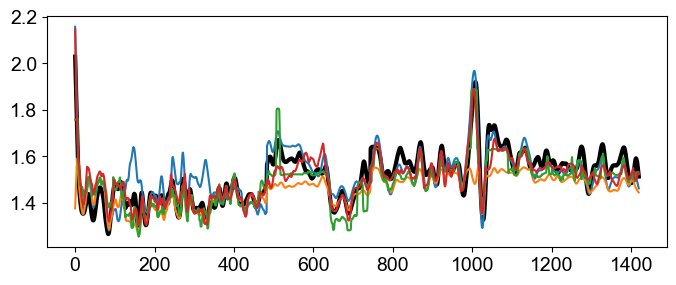

In [34]:
plt.figure(figsize=(8,3))
plt.plot(test_logs['true'], lw=3,color='k')
plt.plot(test_logs['lr'])
plt.plot(test_logs['svr'])
plt.plot(test_logs['rfr'])
plt.plot(test_logs['mlp'])


print('LR:',mean_squared_error(test_logs['true'],test_logs['lr'], squared=False))
print('SVR:',mean_squared_error(test_logs['true'],test_logs['svr'], squared=False))
print('RFR:',mean_squared_error(test_logs['true'],test_logs['rfr'], squared=False))
print('MLP:',mean_squared_error(test_logs['true'],test_logs['mlp'], squared=False))

In [8]:
estimator_rfr.best_params_


{'RFR__max_depth': 10,
 'RFR__min_samples_leaf': 7,
 'RFR__min_samples_split': 2,
 'RFR__n_estimators': 1200}

In [9]:
estimator_svr.best_params_

{'SVR__C': 1.0, 'SVR__gamma': 0.01, 'SVR__kernel': 'rbf'}

In [10]:
estimator_mlp.best_params_

{'MLP__activation': 'relu',
 'MLP__alpha': 0.01,
 'MLP__hidden_layer_sizes': (8, 8),
 'MLP__learning_rate': 'constant',
 'MLP__max_iter': 4000,
 'MLP__n_iter_no_change': 10,
 'MLP__solver': 'lbfgs'}

# Predictions on BO-2X and BO-3X

# Tensorflow

In [64]:
#from tensorflow.keras import sequential

#class CustomCallback(keras.callbacks.Callback):
#
#    def on_epoch_end(self, epoch, logs=None):
#        y_test_pred = self.model.predict(X_test)
#        mse = mean_squared_error(y_test, y_test_pred)
#        print(f"Epoch {epoch}: {mse:.2f}")
        
        
def create_model(kernel_initializer='normal', activation='relu'):
    model = keras.Sequential()
    model.add(layers.Dense(100,input_dim=len(features),activation=activation,kernel_initializer=kernel_initializer
                           , kernel_regularizer=regularizers.l2(0.00001)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(100,activation=activation, kernel_regularizer=regularizers.l2(0.00001)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(50,activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
    model.add(layers.Dense(1 ,activation=activation))

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer=tf.keras.optimizers.Adam(0.001))

    return model

# wrap the model using the function you created
clf = KerasRegressor(model=create_model,verbose=0, epochs=200, batch_size=1, fit__validation_data = (X_test,y_test)
                    , validation_batch_size = 1)

# just create the pipeline
pipeline_MLP = Pipeline([('std', StandardScaler()),
    ('clf',clf)
])

pipeline_MLP.fit(X_train, y_train)
plt.figure()
plt.plot(pipeline_MLP.steps[1][1].history_['loss'], label = 'test')
plt.plot(pipeline_MLP.steps[1][1].history_['val_loss'], label = 'val')
plt.legend()
test_logs['mlp'] = pipeline_MLP.predict(X_test)

plt.figure()
plt.plot(test_logs['true'] , label='true')
plt.plot(test_logs['mlp'], label='pred')
plt.legend()
print('MLP:',mean_squared_error(test_logs['true'],test_logs['mlp'], squared=False))

#test_logs['mlp'] = pipeline_MLP.predict(X_test)
#plt.plot(test_logs['true'])
#
#plt.plot(test_logs['mlp'])
#
#print('MLP:',mean_squared_error(test_logs['true'],test_logs['mlp'], squared=False))

KeyboardInterrupt: 

Epoch 1/10


C:\Users\MLO\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


185/185 [==============================] - 0s 750us/step - loss: 0.0402
Epoch 2/10
185/185 [==============================] - 0s 750us/step - loss: 0.0101
Epoch 3/10
185/185 [==============================] - 0s 794us/step - loss: 0.0113
Epoch 4/10
185/185 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 5/10
185/185 [==============================] - 0s 915us/step - loss: 0.0117
Epoch 6/10
185/185 [==============================] - 0s 894us/step - loss: 0.0118
Epoch 7/10
185/185 [==============================] - 0s 754us/step - loss: 0.0122
Epoch 8/10
185/185 [==============================] - 0s 738us/step - loss: 0.0100
Epoch 9/10
185/185 [==============================] - 0s 767us/step - loss: 0.0134
Epoch 10/10
185/185 [==============================] - 0s 752us/step - loss: 0.0116
Best: -0.104701 using {'clf__batch_size': 20, 'clf__epochs': 10}
-0.156512 (0.036159) with: {'clf__batch_size': 10, 'clf__epochs': 10}
-0.154332 (0.042507) with: {'clf__batch_size': 

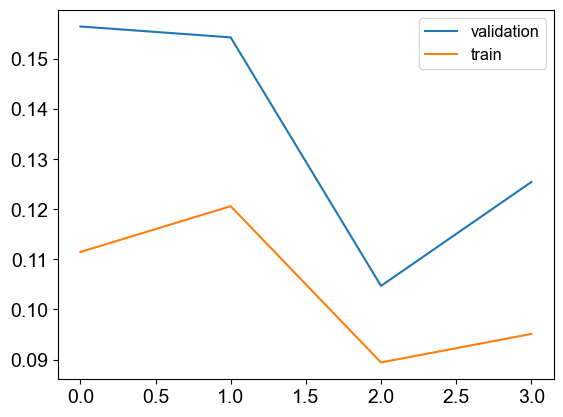

In [27]:
class CustomCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = self.model.predict(x_val)
        mse = mean_squared_error(y_val, y_val_pred)
        print(f"Epoch {epoch}: {mse:.2f}")
        
        
#from tensorflow.keras import sequential
def create_model(kernel_initializer='normal', activation='relu'):
    model = keras.Sequential()
    model.add(layers.Dense(5,input_dim=len(features),activation=activation,kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.005)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10,activation=activation,kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.005)))
#    model.add(layers.Dense(3,activation='relu',kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(1 ,activation=activation))

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer=tf.keras.optimizers.Adam(0.1))

    return model

# wrap the model using the function you created
clf = KerasRegressor(model=create_model,verbose=1)

# just create the pipeline
param_grid_MLP = [{ 'clf__batch_size': [10, 20],
 'clf__epochs': [10, 20]}]

logo = LeaveOneGroupOut().split(X_train, y_train, groups=wells_train)


grid = GridSearchCV(estimator=pipeline_MLP, param_grid=param_grid_MLP, n_jobs=-1, cv=logo, return_train_score=True, scoring='neg_root_mean_squared_error')
grid_result = grid.fit(X_train, np.squeeze(y_train))

#clf_mlp.fit(X_train, np.squeeze(y_train))
#test_logs['mlp'] = clf_mlp.predict(X_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

test_scores = grid_result.cv_results_['mean_test_score']
train_scores = grid_result.cv_results_['mean_train_score'] 
#'mean_test_score': array([-0.15079611, -0.15745158, -0.12269899, -0.12267689]),
# 'std_test_score': array([0.05027158, 0.03339824, 0.0240863 , 0.01774399]),
plt.plot(test_scores*-1, label='validation')
plt.plot(train_scores*-1, label='train')
plt.legend(loc='best')
plt.show()

Epoch 1/10


C:\Users\MLO\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


185/185 [==============================] - 0s 767us/step - loss: 0.0395
Epoch 2/10
185/185 [==============================] - 0s 757us/step - loss: 0.0135
Epoch 3/10
185/185 [==============================] - 0s 760us/step - loss: 0.0125
Epoch 4/10
185/185 [==============================] - 0s 772us/step - loss: 0.0127
Epoch 5/10
185/185 [==============================] - 0s 798us/step - loss: 0.0118
Epoch 6/10
185/185 [==============================] - 0s 761us/step - loss: 0.0114
Epoch 7/10
185/185 [==============================] - 0s 895us/step - loss: 0.0116
Epoch 8/10
185/185 [==============================] - 0s 890us/step - loss: 0.0128
Epoch 9/10
185/185 [==============================] - 0s 852us/step - loss: 0.0131
Epoch 10/10
48/48 [==============================] - 0s 571us/step
MLP: 0.07709758894110758


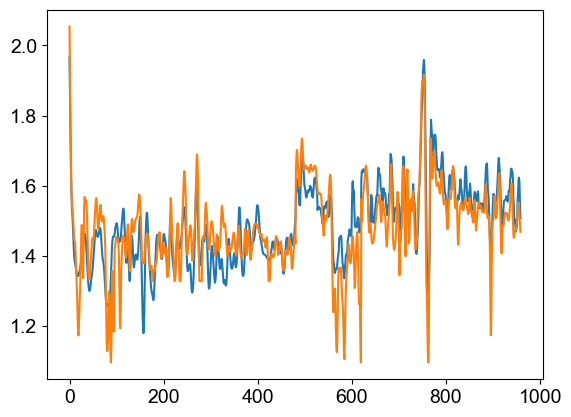

In [16]:
pipeline_MLP.set_params(**grid_result.best_params_)
pipeline_MLP.fit(X_train, y_train)


In [22]:
history = pipeline_MLP.fit(
    X_train,
    y_train)

Epoch 1/10


C:\Users\MLO\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


185/185 [==============================] - 0s 770us/step - loss: 0.0342
Epoch 2/10
185/185 [==============================] - 0s 751us/step - loss: 0.0107
Epoch 3/10
185/185 [==============================] - 0s 727us/step - loss: 0.0112
Epoch 4/10
185/185 [==============================] - 0s 787us/step - loss: 0.0117
Epoch 5/10
185/185 [==============================] - 0s 750us/step - loss: 0.0123
Epoch 6/10
185/185 [==============================] - 0s 919us/step - loss: 0.0129
Epoch 7/10
185/185 [==============================] - 0s 923us/step - loss: 0.0120
Epoch 8/10
185/185 [==============================] - 0s 824us/step - loss: 0.0126
Epoch 9/10
185/185 [==============================] - 0s 742us/step - loss: 0.0133
Epoch 10/10
185/185 [==============================] - 0s 767us/step - loss: 0.0129


In [26]:
test = pipeline_MLP.predict(X_test)

48/48 [==============================] - 0s 683us/step


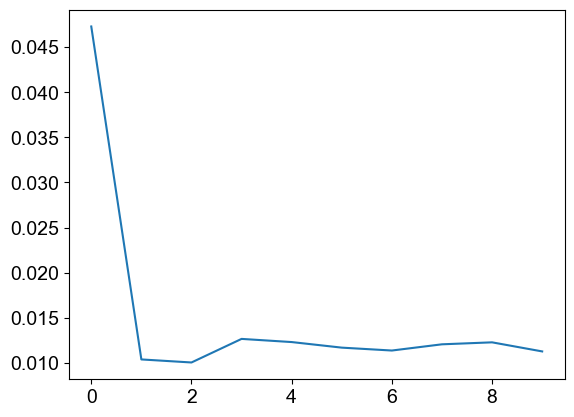

In [18]:
plt.plot(history.steps[1][1].history_['loss'])

# CrossVal for Keras

In [5]:
class KerasRegressorMod(KerasRegressor):
    def fit(self, X, y, sample_weight=None, validation_data=None):
        self.fit__validation_data = validation_data
        super().fit(X, y, sample_weight)
        vars(self).pop('fit__validation_data')
        return self
    
clf = KerasRegressorMod(model=create_model,verbose=1)

# just create the pipeline
pipeline_MLP = Pipeline([('std', StandardScaler()),
    ('clf',clf)])

In [9]:
history = pipeline_MLP.fit(X_train, y_train, clf__validation_data=(X_test, y_test))

116/116 [==============================] - 0s 2ms/step - loss: 0.0671 - val_loss: 0.2517


In [11]:
history.steps[1][1].history_

defaultdict(list,
            {'loss': [0.06713560223579407], 'val_loss': [0.2517448961734772]})

In [ ]:
plt.plot(history.steps[1][1].history_['loss'])

Iter #: 0
26/26 [==============================] - 0s 698us/step
Iter #: 1
32/32 [==============================] - 0s 567us/step
Iter #: 2
24/24 [==============================] - 0s 652us/step
Iter #: 3
35/35 [==============================] - 0s 610us/step


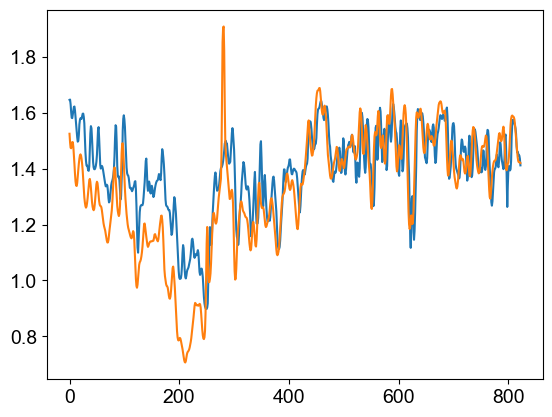

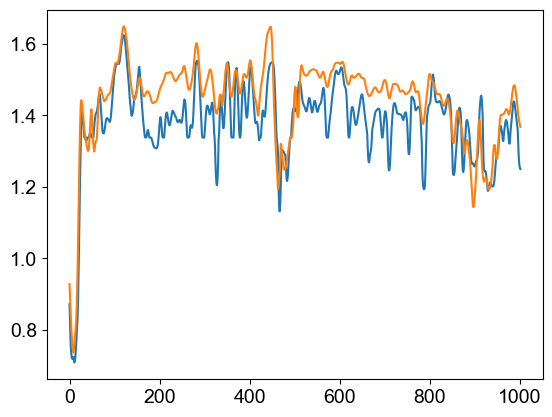

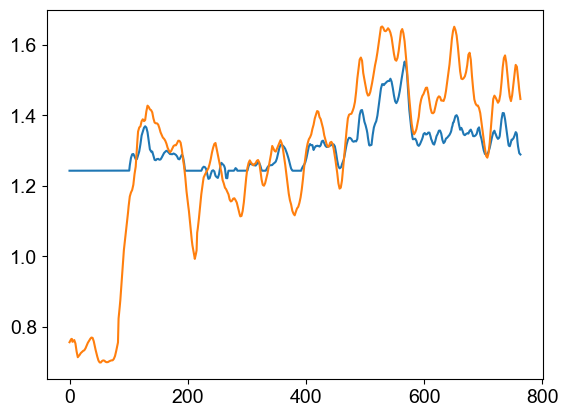

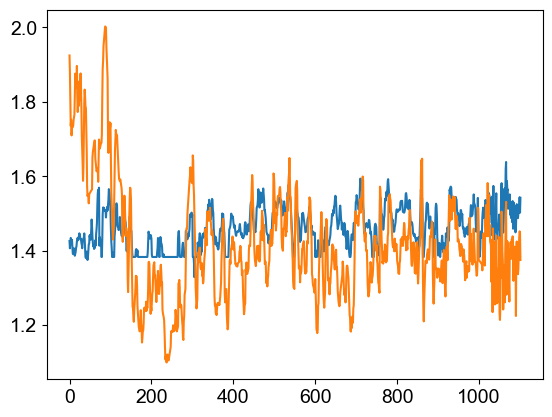

In [37]:
X_tr = df.loc[df['UWI'].isin(train_wells), features]
y_tr = df.loc[df['UWI'].isin(train_wells), target]
X_ts = df.loc[df['UWI'].isin(test_wells), features]
y_ts = df.loc[df['UWI'].isin(test_wells), target]

logo = LeaveOneGroupOut()
k=0

nested_score_LR = []
nested_score_RFR = []
nested_score_SVR = []
nested_score_MLP = []

k=0
for train_index, test_index in logo.split(X_tr, y_tr, wells_train):
    print('Iter #:', k)
    X_trn, X_val = X_tr.iloc[train_index], X_tr.iloc[test_index]
    y_trn, y_val = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    scale = StandardScaler()
    X_trn = scale.fit_transform(X_trn)

    #This is the change
    X_val = scale.transform(X_val)
    
    clf.fit(X_trn, y_trn)
    test = clf.predict(X_val)
    #history = pipeline_MLP.fit(X_trn, y_trn, clf__validation_data=(X_val, y_val))
    
    plt.figure()
    plt.plot(test)
    plt.plot(np.array(y_val))
    
    #print('test well :', df.loc[X_val.index[-1]]['UWI'])
    k+=1

In [40]:
clf.history_

defaultdict(list, {'loss': [0.07207629084587097]})

In [84]:
history.steps[1][1].history_

defaultdict(list,
            {'loss': [0.10522375255823135], 'val_loss': [0.41855746507644653]})

In [120]:
#4.77**2

22.752899999999997

In [131]:
from uncertainties import ufloat
from pint import UnitRegistry 
4.77
#RMSE of test data (#1 DTC): 4.77
#RMSE of test data (#2 DTS): 17.28

DT = ufloat(200,(17.28)) *u.microsecond / u.ft

format((1 / DT).to('km/s'), '.2f')

'1.52+/-0.13 kilometer / second'

In [132]:
0.3048 * (1e6/(200-17.28/2) - 1e6/(200+17.28/2))

131.9197939963475

In [119]:
0.3048 * (1e6/150 - 1e6/159.676)

123.1345474586035

# Nested CV (LeaveOneGroupOut)

In [ ]:
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR


regr1 = LinearRegression()
regr2 = RandomForestRegressor(random_state=42)
regr3 = SVR()
regr4 = MLPRegressor(random_state=42)


# Building the pipelines
pipe_LR = Pipeline([('std', StandardScaler()),
                  ('LR', regr1)])

pipe_RFR = Pipeline([('RFR', regr2)])

pipe_SVR = Pipeline([('std', StandardScaler()),
                  ('SVR', regr3)])


pipe_MLP = Pipeline([('std', StandardScaler()), ('MLP', regr4)])


# Setting up the parameter grids
param_grid_LR = [{}]

param_grid_RFR = [{'RFR__max_depth': list(range(1, 10)) + [None],
                  'RFR__n_estimators': [100,200,300,400] }]

param_grid_SVR = [{'SVR__C': np.power(10., np.arange(-4, 4)),
                  'SVR__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}]

param_grid_MLP = [{"MLP__hidden_layer_sizes": [(100), (10,10), (20,20), (50,50), (100,100)],
                  "MLP__activation": ["relu"],
                  'MLP__learning_rate': ['adaptive'],
                  'MLP__solver' : ['adam'],
                  "MLP__alpha": np.power(10., np.arange(-6, 0)),
                  "MLP__max_iter": [4000]}] #np.arange(100,8000,500)

In [ ]:
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

X_tr = df.loc[df['UWI'].isin(train_wells), features]
y_tr = df.loc[df['UWI'].isin(train_wells), target]
X_ts = df.loc[df['UWI'].isin(test_wells), features]
y_ts = df.loc[df['UWI'].isin(test_wells), target]

logo = LeaveOneGroupOut()
k=0

nested_score_LR = []
nested_score_RFR = []
nested_score_SVR = []
nested_score_MLP = []

for train_index, test_index in logo.split(X_tr, y_tr, wells_train):
    print('Iter #:', k)
    X_trn, X_tst = X_tr.iloc[train_index], X_tr.iloc[test_index]
    y_trn, y_tst = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    print('test well :', df.loc[X_tst.index[-1]]['UWI'])


    wells_train_inner = train_wells.copy()
    wells_train_inner.remove(df.loc[X_tst.index[-1]]['UWI'])
    
    print('training wells:', wells_train_inner)
    
    X_tr_ = df.loc[df['UWI'].isin(wells_train_inner), features].values
    y_tr_ = np.squeeze(df.loc[df['UWI'].isin(wells_train_inner), target].values)


    wells_train_inner = df.loc[df['UWI'].isin(wells_train_inner), 'UWI'].values
    
    #LR
    gcv_LR = GridSearchCV(pipe_LR, param_grid_LR, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut())
    results_LR = gcv_LR.fit(X_tr_, y_tr_, groups=wells_train_inner)
    model_LR = results_LR.best_estimator_.fit(X_tr_, y_tr_)
    model_score_LR = model_LR.predict(X_tst)
    nested_score_LR.append(mean_squared_error(y_tst,model_score_LR, squared=False))
    
    #RFR
    gcv_RFR = GridSearchCV(pipe_RFR, param_grid_RFR, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut())
    results_RFR = gcv_RFR.fit(X_tr_, y_tr_, groups=wells_train_inner)
    model_RFR = results_RFR.best_estimator_.fit(X_tr_, y_tr_)
    model_score_RFR = model_RFR.predict(X_tst)
    nested_score_RFR.append(mean_squared_error(y_tst,model_score_RFR, squared=False))
    
    
    #SVR
    gcv_SVR = GridSearchCV(pipe_SVR, param_grid_SVR, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut())
    results_SVR = gcv_SVR.fit(X_tr_, y_tr_, groups=wells_train_inner)
    model_SVR = results_SVR.best_estimator_.fit(X_tr_, y_tr_)
    model_score_SVR = model_SVR.predict(X_tst)
    nested_score_SVR.append(mean_squared_error(y_tst,model_score_SVR, squared=False))
    
    #MLP
    gcv_MLP = GridSearchCV(pipe_MLP, param_grid_MLP, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut())
    results_MLP = gcv_MLP.fit(X_tr_, y_tr_, groups=wells_train_inner)
    model_MLP = results_MLP.best_estimator_.fit(X_tr_, y_tr_)
    model_score_MLP = model_MLP.predict(X_tst)
    nested_score_MLP.append(mean_squared_error(y_tst,model_score_MLP, squared=False))
    
    k+=1



In [ ]:
plt.plot(np.arange(4), nested_score_LR  , label = 'LR')
plt.plot(np.arange(4), nested_score_RFR , label = 'RFR')
plt.plot(np.arange(4), nested_score_SVR , label = 'SVR')
plt.plot(np.arange(4), nested_score_MLP , label = 'MLP')
plt.ylabel('RMSE')
plt.xlabel('Validation Well')
plt.xticks([0,1,2,3],labels = ['BOJE-2C', 'JUDE-1', 'SIAH_NE-01X', 'VALDEMAR-2H'])
plt.legend()


plt.fill_between(
    np.arange(4),
    nested_score_LR - np.std(nested_score_LR ),
    nested_score_LR + np.std(nested_score_LR ),
    alpha=0.1,
    color="C0"
)

plt.fill_between(
    np.arange(4),
    nested_score_RFR - np.std(nested_score_RFR ),
    nested_score_RFR + np.std(nested_score_RFR ),
    alpha=0.1,
    color="C1"
)

plt.fill_between(
    np.arange(4),
    nested_score_SVR - np.std(nested_score_SVR ),
    nested_score_SVR + np.std(nested_score_SVR ),
    alpha=0.1,
    color="C2"
)

plt.fill_between(
    np.arange(4),
    nested_score_MLP - np.std(nested_score_MLP ),
    nested_score_MLP + np.std(nested_score_MLP ),
    alpha=0.1,
    color="C2"
)

print('mean score LR :' , np.mean(nested_score_LR ) , 'Std:', np.std(nested_score_LR ))
print('mean score RFR:' , np.mean(nested_score_RFR) , 'Std:', np.std(nested_score_RFR))
print('mean score SVR:' , np.mean(nested_score_SVR) , 'Std:', np.std(nested_score_SVR))
print('mean score MLP:' , np.mean(nested_score_MLP) , 'Std:', np.std(nested_score_MLP))


In [ ]:
nested_score_MLP

In [ ]:
print('mean score LR :' , np.mean(nested_score_LR ) , 'Std:', np.std(nested_score_LR ))
print('mean score RFR:' , np.mean(nested_score_RFR) , 'Std:', np.std(nested_score_RFR))
print('mean score SVR:' , np.mean(nested_score_SVR) , 'Std:', np.std(nested_score_SVR))
print('mean score MLP:' , np.mean(nested_score_MLP) , 'Std:', np.std(nested_score_MLP))

In [ ]:
results_MLP.best_estimator_

In [ ]:
#logo = LeaveOneGroupOut().split(X_train, y_train, groups=wells_train)
#nested_score = cross_val_score(results.best_estimator_, X_train, y_train, scoring='neg_root_mean_squared_error', cv=logo, groups=wells_train)

# Nested CV with RFE

In [ ]:
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=10)


regr1 = LinearRegression()
regr2 = RandomForestRegressor(random_state=42)
regr3 = SVR()
regr4 = MLPRegressor(random_state=42)


# Building the pipelines
pipe_LR = Pipeline([('s',rfe) , ('std', StandardScaler()),
                  ('LR', regr1)])

pipe_RFR = Pipeline([('s',rfe), ('RFR', regr2)])

pipe_SVR = Pipeline([('s',rfe) , ('std', StandardScaler()),
                  ('SVR', regr3)])


pipe_MLP = Pipeline([('s',rfe), ('std', StandardScaler()), ('MLP', regr4)])


# Setting up the parameter grids
param_grid_LR = [{}]

param_grid_RFR = [{'RFR__max_depth': list(range(1, 10)) + [None],
                  'RFR__n_estimators': [100,200,300,400] }]

param_grid_SVR = [{'SVR__C': np.power(10., np.arange(-4, 4)),
                  'SVR__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}]

param_grid_MLP = [{"MLP__hidden_layer_sizes": [(100), (10,10), (20,20), (50,50), (100,100)],
                  "MLP__activation": ["relu"],
                  'MLP__learning_rate': ['adaptive'],
                  'MLP__solver' : ['adam'],
                  "MLP__alpha": np.power(10., np.arange(-6, 0)),
                  "MLP__max_iter": [4000]}] #np.arange(100,8000,500)

In [ ]:
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

X_tr = df.loc[df['UWI'].isin(train_wells), features]
y_tr = df.loc[df['UWI'].isin(train_wells), target]
X_ts = df.loc[df['UWI'].isin(test_wells), features]
y_ts = df.loc[df['UWI'].isin(test_wells), target]

logo = LeaveOneGroupOut()
k=0

nested_score_LR = []
nested_score_RFR = []
nested_score_SVR = []
nested_score_MLP = []

for train_index, test_index in logo.split(X_tr, y_tr, wells_train):
    print('Iter #:', k)
    X_trn, X_tst = X_tr.iloc[train_index], X_tr.iloc[test_index]
    y_trn, y_tst = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    print('test well :', df.loc[X_tst.index[-1]]['UWI'])


    wells_train_inner = train_wells.copy()
    wells_train_inner.remove(df.loc[X_tst.index[-1]]['UWI'])
    
    print('training wells:', wells_train_inner)
    
    X_tr_ = df.loc[df['UWI'].isin(wells_train_inner), features].values
    y_tr_ = np.squeeze(df.loc[df['UWI'].isin(wells_train_inner), target].values)


    wells_train_inner = df.loc[df['UWI'].isin(wells_train_inner), 'UWI'].values
    
    #LR
    gcv_LR = GridSearchCV(pipe_LR, param_grid_LR, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut())
    results_LR = gcv_LR.fit(X_tr_, y_tr_, groups=wells_train_inner)
    model_LR = results_LR.best_estimator_.fit(X_tr_, y_tr_)
    model_score_LR = model_LR.predict(X_tst)
    nested_score_LR.append(mean_squared_error(y_tst,model_score_LR, squared=False))
    
    #RFR
    gcv_RFR = GridSearchCV(pipe_RFR, param_grid_RFR, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut())
    results_RFR = gcv_RFR.fit(X_tr_, y_tr_, groups=wells_train_inner)
    model_RFR = results_RFR.best_estimator_.fit(X_tr_, y_tr_)
    model_score_RFR = model_RFR.predict(X_tst)
    nested_score_RFR.append(mean_squared_error(y_tst,model_score_RFR, squared=False))
    
    
    #SVR
    gcv_SVR = GridSearchCV(pipe_SVR, param_grid_SVR, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut())
    results_SVR = gcv_SVR.fit(X_tr_, y_tr_, groups=wells_train_inner)
    model_SVR = results_SVR.best_estimator_.fit(X_tr_, y_tr_)
    model_score_SVR = model_SVR.predict(X_tst)
    nested_score_SVR.append(mean_squared_error(y_tst,model_score_SVR, squared=False))
    
    #MLP
    gcv_MLP = GridSearchCV(pipe_MLP, param_grid_MLP, scoring='neg_root_mean_squared_error', cv=LeaveOneGroupOut())
    results_MLP = gcv_MLP.fit(X_tr_, y_tr_, groups=wells_train_inner)
    model_MLP = results_MLP.best_estimator_.fit(X_tr_, y_tr_)
    model_score_MLP = model_MLP.predict(X_tst)
    nested_score_MLP.append(mean_squared_error(y_tst,model_score_MLP, squared=False))
    
    k+=1



In [ ]:
plt.plot(np.arange(4), nested_score_LR  , label = 'LR')
plt.plot(np.arange(4), nested_score_RFR , label = 'RFR')
plt.plot(np.arange(4), nested_score_SVR , label = 'SVR')
plt.plot(np.arange(4), nested_score_MLP , label = 'MLP')
plt.ylabel('RMSE')
plt.xlabel('Validation Well')
plt.xticks([0,1,2,3],labels = ['BOJE-2C', 'JUDE-1', 'SIAH_NE-01X', 'VALDEMAR-2H'])
plt.legend()


plt.fill_between(
    np.arange(4),
    nested_score_LR - np.std(nested_score_LR ),
    nested_score_LR + np.std(nested_score_LR ),
    alpha=0.1,
    color="C0"
)

plt.fill_between(
    np.arange(4),
    nested_score_RFR - np.std(nested_score_RFR ),
    nested_score_RFR + np.std(nested_score_RFR ),
    alpha=0.1,
    color="C1"
)

plt.fill_between(
    np.arange(4),
    nested_score_SVR - np.std(nested_score_SVR ),
    nested_score_SVR + np.std(nested_score_SVR ),
    alpha=0.1,
    color="C2"
)

plt.fill_between(
    np.arange(4),
    nested_score_MLP - np.std(nested_score_MLP ),
    nested_score_MLP + np.std(nested_score_MLP ),
    alpha=0.1,
    color="C2"
)

print('mean score LR :' , np.mean(nested_score_LR ) , 'Std:', np.std(nested_score_LR ))
print('mean score RFR:' , np.mean(nested_score_RFR) , 'Std:', np.std(nested_score_RFR))
print('mean score SVR:' , np.mean(nested_score_SVR) , 'Std:', np.std(nested_score_SVR))
print('mean score MLP:' , np.mean(nested_score_MLP) , 'Std:', np.std(nested_score_MLP))


In [ ]:
mean score LR : 0.12636835831088702 Std: 0.03289854152198718
mean score RFR: 0.11639220359273304 Std: 0.026268406898577686
mean score SVR: 0.10196428215112074 Std: 0.03725603668502954
mean score MLP: 0.10148377149739016 Std: 0.05692889168846151
        
        
mean score LR : 0.11630283448532498 Std: 0.059124087596068776
mean score RFR: 0.11248545517280101 Std: 0.023239336498082918
mean score SVR: 0.11043857509214851 Std: 0.047871997594650495
mean score MLP: 0.08996400743992972 Std: 0.045256619671477455